# Etapa 01 – Coleta dos Dados
### Equipe: Ana Carolina Estrela, Eduardo Ikeda, Vinicius Maciel
### Estado: Pernambuco

A extração inicial dos dados foi feita pelo proprio site do Datasus e sua extração foi feita utilizando o tabwin. As fases subsequentes foram feitas utilizando a biblioteca Pandas do python


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 4.a – Quantos registros de AIH existem para cada mês e em cada estado?

In [2]:
chunksize = 100_000  
resultados = {}

for chunk in pd.read_csv("combined_data.csv", sep=",", encoding="latin1", chunksize=chunksize, low_memory=False):
    chunk.columns = chunk.columns.str.strip()
    
    contagem = chunk.groupby(["ANO_CMPT", "MES_CMPT"]).size()
    
    for idx, valor in contagem.items():
        resultados[idx] = resultados.get(idx, 0) + valor

df_resultado = pd.DataFrame(list(resultados.items()), columns=["(ano, mes)", "quantidade"])
df_resultado[["ano", "mes"]] = pd.DataFrame(df_resultado["(ano, mes)"].tolist(), index=df_resultado.index)
df_resultado = df_resultado.drop(columns="(ano, mes)")

df_resultado = df_resultado.sort_values(["ano", "mes"])
print(df_resultado)
df_resultado.to_csv("csvfiles/4a_resultado_mes_ano.csv", index=False, encoding="utf-8")




    quantidade   ano  mes
0        46340  2019    1
1        44356  2019    2
2        47317  2019    3
3        49156  2019    4
4        51443  2019    5
5        49068  2019    6
6        50727  2019    7
7        50623  2019    8
8        48911  2019    9
9       101702  2019   10
10       49107  2019   11
11       46717  2019   12
12       48307  2020    1
13       44232  2020    2
14       44661  2020    3
15       32876  2020    4
16       33907  2020    5
17       36278  2020    6
18       41780  2020    7
19       41711  2020    8
20       41155  2020    9
21       41630  2020   10
22       43028  2020   11
23       40974  2020   12
24       41796  2021    1
25       40255  2021    2
26       43045  2021    3
27       45068  2021    4
28       49616  2021    5
29       49946  2021    6
30       49080  2021    7
31       48398  2021    8
32       46150  2021    9
33       46592  2021   10
34       48340  2021   11
35        3759  2021   12


In [3]:
resultados = {} 

for chunk in pd.read_csv("combined_data.csv", sep=",", encoding="latin1", chunksize=chunksize, low_memory=False):
    chunk.columns = chunk.columns.str.strip()
    
    contagem = chunk.groupby("ANO_CMPT").size()
    
    for idx, valor in contagem.items():
        resultados[idx] = resultados.get(idx, 0) + valor

df_resultado = pd.DataFrame(list(resultados.items()), columns=["ano", "quantidade"])

df_resultado = df_resultado.sort_values("ano").reset_index(drop=True)
print(df_resultado)
df_resultado.to_csv("4a_resultado_ano.csv", index=False, encoding="utf-8")


    ano  quantidade
0  2019      635467
1  2020      490539
2  2021      557344
3  2022      599329
4  2023      617948
5  2024      495682


### 4.b – Quantos registros de Procedimentos de Saúde foram importados?

In [4]:
total_solicitados = 0
total_realizados = 0
total_ambos = 0

for chunk in pd.read_csv("combined_data.csv", sep=",", encoding="latin1", 
                        chunksize=chunksize, low_memory=False):
    chunk.columns = chunk.columns.str.strip()
    
    solicitados_chunk = chunk['PROC_SOLIC'].notna().sum()
    total_solicitados += solicitados_chunk
    
    realizados_chunk = chunk['PROC_REA'].notna().sum()
    total_realizados += realizados_chunk
    
    ambos_chunk = chunk[['PROC_SOLIC', 'PROC_REA']].notna().any(axis=1).sum()
    total_ambos += ambos_chunk

print(f"Total de registros com pelo menos um procedimento: {total_ambos}")

dados = {
    'Tipo': ['SOLICITADOS', 'REALIZADOS', 'COM_PELO_MENOS_UM'],
    'Quantidade': [total_solicitados, total_realizados, total_ambos]
}

df_resultados = pd.DataFrame(dados)

df_resultados.to_csv("csvfiles/4b_procedimentos.csv", index=False, encoding="utf-8")

Total de registros com pelo menos um procedimento: 3570342


### 4.c – Quantos registros de CID foram importados?


In [5]:
cid_unicos = set()

for chunk in pd.read_csv("combined_data.csv", sep=",", encoding="latin1", 
                        chunksize=chunksize, low_memory=False):
    chunk.columns = chunk.columns.str.strip()
    
    cid_principal = chunk['DIAG_PRINC'].dropna().unique()
    cid_unicos.update(cid_principal)
    
    cid_secundario = chunk['DIAG_SECUN'].dropna().unique()
    cid_unicos.update(cid_secundario)

total_cid_unicos = len(cid_unicos)
print(f"Total de CID únicos (principal + secundário): {total_cid_unicos}")

df_resultado = pd.DataFrame({
    'Descricao': ['Total de CID únicos (DIAG_PRINC + DIAG_SECUN)'],
    'Quantidade': [total_cid_unicos]
})

df_resultado.to_csv("csvfiles/4c_total_cid_unicos.csv", index=False, encoding="utf-8")

Total de CID únicos (principal + secundário): 8600


### 4.d – Quantos registros de estabelecimentos (CNES) foram importados?

In [6]:
cnes_por_mes = {}
todos_cnes = set()  


for chunk in pd.read_csv("combined_data.csv", sep=",", encoding="latin1", 
                        chunksize=chunksize, low_memory=False):
    chunk.columns = chunk.columns.str.strip()
    
    if all(col in chunk.columns for col in ['CNES', 'ANO_CMPT', 'MES_CMPT']):
        chunk_valid = chunk[chunk['CNES'].notna()].copy()
        chunk_valid['chave_mes'] = chunk_valid['ANO_CMPT'].astype(str) + '-' + chunk_valid['MES_CMPT'].astype(str).str.zfill(2)
        
        cnes_unicos_chunk = chunk_valid['CNES'].unique()
        todos_cnes.update(cnes_unicos_chunk)
        
        for chave in chunk_valid['chave_mes'].unique():
            cnes_mes = chunk_valid[chunk_valid['chave_mes'] == chave]['CNES'].unique()
            if chave not in cnes_por_mes:
                cnes_por_mes[chave] = set()
            cnes_por_mes[chave].update(cnes_mes)

meses = sorted(cnes_por_mes.keys())
quantidades_mensais = [len(cnes_por_mes[mes]) for mes in meses]
total_unico_periodo = len(todos_cnes)  

print(f"Total de CNES únicos no período completo: {total_unico_periodo}")
print(f"Soma das quantidades mensais: {sum(quantidades_mensais)}")
print(f"Número de meses analisados: {len(meses)}")

df = pd.DataFrame({'Mes': meses, 'CNES_Unicos': quantidades_mensais})
df.to_csv("csvfiles/cnes_por_mes_simples.csv", index=False, encoding="utf-8")

with open("txtfiles/total_cnes_unico_periodo.txt", "w", encoding="utf-8") as f:
    f.write(f"Total de CNES únicos no período completo: {total_unico_periodo}\n")
    f.write(f"Período analisado: {meses[0]} a {meses[-1]}\n")
    f.write(f"Número de meses: {len(meses)}\n")


Total de CNES únicos no período completo: 319
Soma das quantidades mensais: 17485
Número de meses analisados: 72


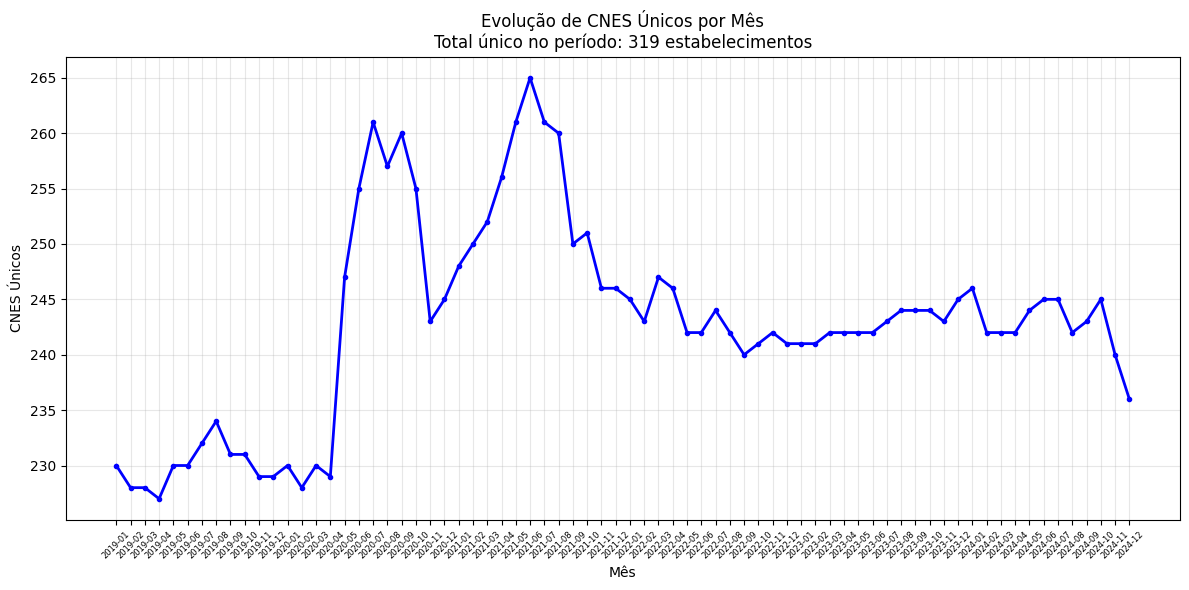

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(meses, quantidades_mensais, 'b-o', linewidth=2, markersize=3)
plt.title(f'Evolução de CNES Únicos por Mês\nTotal único no período: {total_unico_periodo} estabelecimentos')
plt.xlabel('Mês')
plt.ylabel('CNES Únicos')
plt.xticks(rotation=45, fontsize=6)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evolucao_cnes_simples.png', dpi=300)
plt.show()